#ch06-How to Develop a 1D Generative Adversarial Network From Scratch in Keras

- [How to Develop a 1D Generative Adversarial Network From Scratch in Keras](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/) by [Jason Brownlee](https://machinelearningmastery.com/author/jasonb/) on Sept 1, 2020 in [Generative Adversarial Networks](https://machinelearningmastery.com/category/generative-adversarial-networks/)
- Excerpt by Ivan HP Lin (WIP)

Generative Adversarial Networks (GAN) are a deep learning architecture for training powerful generator models.

A generator model is capable of generating new artificial samples that plausibly could have come from an existing distribution of samples.

GANs are comprised of both generator and discriminator models. The generator is responsible for generating new samples from the domain, and the discriminator is responsible for classifying whether samples are real or fake (generated). 
* **Importantly, the performance of the discriminator model is used to update both the model weights of the discriminator itself and the generator model. This means that the generator never actually sees examples from the domain and is adapted based on how well the discriminator performs**

In this tutorial, we will select a simple one-dimensional function and use it as the basis for developing and evaluating a generative adversarial network from scratch using the Keras deep learning library.

After completing this tutorial, you will know:

- The benefit of developing a generative adversarial network from scratch for a simple one-dimensional function.
- How to develop separate discriminator and generator models, as well as a composite model for training the generator via the discriminator’s predictive behavior.
- How to subjectively evaluate generated samples in the context of real examples from the problem domain.

# 0.. Tutorial Overview
This tutorial is divided into six parts; they are:

1. [Select a One-Dimensional Function](https://colab.research.google.com/drive/1ofGxmuwL0o8hXc5rAbyrPdnAx5P-AKr_#scrollTo=no-uCM_HCXZI&line=1&uniqifier=1)
2. Define a Discriminator Model
3. Define a Generator Model
4. Training the Generator Model
5. Evaluating the Performance of the GAN
6. Complete Example of Training the GAN

# 1.. Select a One-Dimensional Function

We will use a simple function of $x^2$; that is, the function will return the square of the input. You might remember this function from high school algebra as the u-shaped function.

We can define the input domain as real values between $[-0.5, 0.5]$ and calculate the output value for each input value in this linear range, then plot the results to get an idea of how inputs relate to outputs.

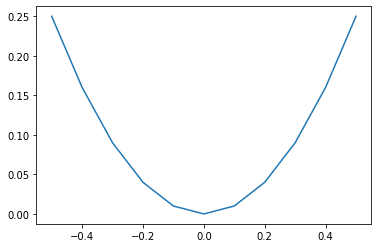

In [16]:
# demonstrate simple x^2 function
from matplotlib import pyplot

# simple function
def calculate(x):
	return x * x

# define inputs
inputs = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
# calculate outputs
outputs = [calculate(x) for x in inputs]
# plot the result
pyplot.plot(inputs, outputs)
pyplot.show()

We can generate random samples or points from the function.

This can be achieved by generating random values between $[-0.5, 0.5]$ and calculating the associated output value. Repeating this many times will give a sample of points from the function, e.g. “real samples.”

Plotting these samples using a scatter plot will show the same u-shape plot, although comprised of the individual random samples.

First, we generate uniformly random values between $[0, 1]$, then shift them to the range $[-0.5, 0.5]$. We then calculate the output value for each randomly generated input value and combine the arrays into a single NumPy array with $n$ rows (100) and two columns.

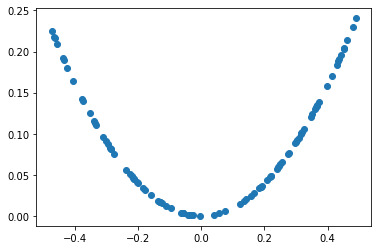

In [17]:
# example of generating random samples from X^2
from numpy.random import rand
from numpy import hstack
from matplotlib import pyplot

# generate randoms sample from x^2
def generate_samples(n=100):
	# generate random inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2 (quadratic)
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	return hstack((X1, X2))

# generate samples
data = generate_samples()
# plot samples
pyplot.scatter(data[:, 0], data[:, 1])
pyplot.show()

We can use this function as a starting point for generating real samples for our discriminator function. Specifically, a sample is comprised of a vector with two elements, one for the input and one for the output of our one-dimensional function.

We can also imagine how a generator model could generate new samples that we can plot and compare to the expected u-shape of the $X^2$ function. Specifically, a generator would output a vector with two elements: one for the input and one for the output of our one-dimensional function.

# 2.. Define a Discriminator Model $D$

## 2.1 Discriminator Model Definition ($D$)

The model must take a sample from our problem, such as a vector with two elements, and output a classification prediction as to whether the sample is real or fake.

This is a binary classification problem.

- Inputs: Sample with two real values.
- Outputs: Binary classification, likelihood the sample is real (or fake).

The problem is very simple, meaning that we don’t need a complex neural network to model it.

* The discriminator model will have one hidden layer with 25 nodes and we will use the [ReLU activation function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) and an appropriate weight initialization method called **He weight initialization**.

* The output layer will have one node for the binary classification using the sigmoid activation function.


The model will minimize the **binary cross entropy loss** function, and the [Adam version of stochastic gradient descent](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) will be used because it is very effective.

The ***define_discriminator()*** function below defines and returns the discriminator model. The function parameterizes the number of inputs to expect, which defaults to two.
```
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
```

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 25)                75        
                                                                 
 dense_17 (Dense)            (None, 1)                 26        
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


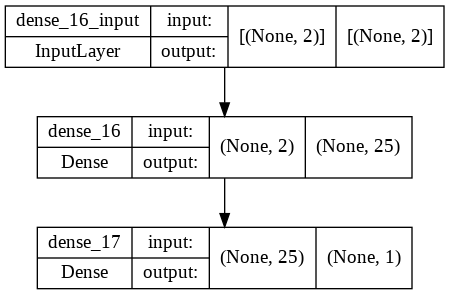

In [18]:
# define the discriminator model
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

# define the standalone discriminator model
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# define the discriminator model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

## 2.2 Sample generation for *real_sample* and *fake_sample*

We could start training this model now with real examples with a class label of one and randomly generated samples with a class label of zero.

There is no need to do this, but the elements we will develop will be useful later, and it helps to see that the discriminator is just a normal neural network model.

First, we can update our generate_samples() function from the prediction section and call it ***generate_real_samples()*** and have it also return the output class labels for the real samples, specifically, an array of 1 values, where class=1 means real.

In [19]:
# generate n real samples with class labels
def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y

Next, we can create a copy of this function for creating fake examples.

In this case, we will generate random values in the range -1 and 1 for both elements of a sample. The output class label for all of these examples is 0.

This function will act as our fake generator model.

In [20]:
# generate n fake samples with class labels
def generate_fake_samples(n):
	# generate inputs in [-1, 1]
	X1 = -1 + rand(n) * 2
	# generate outputs in [-1, 1]
	X2 = -1 + rand(n) * 2
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = zeros((n, 1))
	return X, y

## 2.3 Training the Discriminator ($D$) Model

Next, we need a function to train and evaluate the discriminator model.

This can be achieved by manually enumerating the training epochs and for each epoch generating a half batch of real examples and a half batch of fake examples, and updating the model on each, e.g. one whole batch of examples. The train() function could be used, but in this case, we will use the ***train_on_batch()*** function directly.

The model can then be evaluated on the generated examples and we can report the classification accuracy on the real and fake samples.

The ***train_discriminator()*** function below implements this, training the model for 1,000 batches and using 128 samples per batch (64 fake and 64 real).

```
# train the discriminator model
def train_discriminator(model, n_epochs=1000, n_batch=128):
	half_batch = int(n_batch / 2)
	# run epochs manually
	for i in range(n_epochs):
		# generate real examples
		X_real, y_real = generate_real_samples(half_batch)
		# update model
		model.train_on_batch(X_real, y_real)
  
		# generate fake examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update model
		model.train_on_batch(X_fake, y_fake)
  
		# evaluate the model
		_, acc_real = model.evaluate(X_real, y_real, verbose=0)
		_, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
		print(i, acc_real, acc_fake)
```
We can tie all of this together and train the discriminator model on real and fake examples.  The complete example is listed below.



epoch[0]: [acc_real, acc_fake]=[0.47, 0.84]
epoch[20]: [acc_real, acc_fake]=[0.52, 0.84]
epoch[40]: [acc_real, acc_fake]=[0.58, 0.81]
epoch[60]: [acc_real, acc_fake]=[0.47, 0.84]
epoch[80]: [acc_real, acc_fake]=[0.62, 0.91]
epoch[100]: [acc_real, acc_fake]=[0.72, 0.88]
epoch[120]: [acc_real, acc_fake]=[0.72, 0.83]
epoch[140]: [acc_real, acc_fake]=[0.69, 0.89]
epoch[160]: [acc_real, acc_fake]=[0.7, 0.91]
epoch[180]: [acc_real, acc_fake]=[0.73, 0.92]
epoch[200]: [acc_real, acc_fake]=[0.88, 0.92]
epoch[220]: [acc_real, acc_fake]=[0.77, 0.92]
epoch[240]: [acc_real, acc_fake]=[0.88, 0.94]
epoch[260]: [acc_real, acc_fake]=[0.86, 0.92]
epoch[280]: [acc_real, acc_fake]=[0.94, 0.94]
epoch[300]: [acc_real, acc_fake]=[0.83, 0.95]
epoch[320]: [acc_real, acc_fake]=[0.89, 0.89]
epoch[340]: [acc_real, acc_fake]=[0.91, 0.94]
epoch[360]: [acc_real, acc_fake]=[0.89, 0.92]
epoch[380]: [acc_real, acc_fake]=[0.97, 0.97]
epoch[400]: [acc_real, acc_fake]=[0.94, 0.89]
epoch[420]: [acc_real, acc_fake]=[1.0, 0.

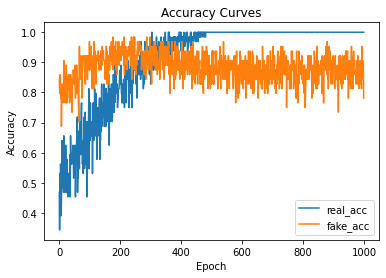

In [6]:
# define and fit a discriminator model
import numpy as np
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# generate n real samples with class labels
def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y

# generate n fake samples with class labels
def generate_fake_samples(n):
	# generate inputs in [-1, 1]
	X1 = -1 + rand(n) * 2
	# generate outputs in [-1, 1]
	X2 = -1 + rand(n) * 2
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = zeros((n, 1))
	return X, y

# train the discriminator model
def train_discriminator(model, n_epochs=1000, n_batch=128, b_plot=1):
	half_batch = int(n_batch / 2)
	acc_history= np.zeros((n_epochs,2), dtype='float64')
  # run epochs manually
	for i in range(n_epochs):
		# generate real examples
		X_real, y_real = generate_real_samples(half_batch)
		# update model
		model.train_on_batch(X_real, y_real)
		
		# generate fake examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update model
		model.train_on_batch(X_fake, y_fake)
		
		# evaluate the model
		_, acc_real = model.evaluate(X_real, y_real, verbose=0)
		_, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
		acc_history[i] = [acc_real, acc_fake]
		if (i%20 == 0):
			print(f'epoch[{i}]: [acc_real, acc_fake]=[{np.round(acc_real,2)}, {np.round(acc_fake,2)}]')

	#plot the accuracy
	if (b_plot):
		pyplot.title('Accuracy Curves')
		pyplot.xlabel('Epoch')
		pyplot.ylabel('Accuracy')
		pyplot.plot(acc_history[:,0], label='real_acc')
		pyplot.plot(acc_history[:,1], label='fake_acc')
		pyplot.legend()
		pyplot.show() 

# define the discriminator model
model = define_discriminator()
# fit the model
train_discriminator(model)


# 3.. Define a Generator Model ($G$)

## 3.1 Generator Model Definition ($G$)

The generator model $G$ takes as input a point from the latent space and generates a new sample, e.g. a vector with both the input and output elements of our function, e.g. $x$ and $x^2$.

A **latent variable** is a hidden or unobserved variable, and a **latent space** is a multi-dimensional vector space of these variables. We can define the size of the latent space for our problem and the shape or distribution of variables in the latent space.

- latent space has no meaning until the generator model starts assigning meaning to points in the space as it learns. 
- After training, points in the latent space will correspond to points in the output space, e.g. in the space of generated samples.

We will define a small latent space of five dimensions and use the standard approach in the GAN literature of using a Gaussian distribution for each variable in the latent space. We will generate new inputs by drawing random numbers from a standard Gaussian distribution, i.e. mean of zero and a standard deviation of one.

* **Inputs**: Point in latent space, e.g. a five-element vector of Gaussian random numbers.
* **Outputs**: Two-element vector representing a generated sample for our function ($x$ and $x^2$).

The generator model will be small like the discriminator model.



The generator model will be small like the discriminator model.

It will have a single hidden layer with five nodes and will use the [ReLU activation function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) and the He weight initialization. The output layer will have two nodes for the two elements in a generated vector and will use a **linear activation function**.

* A **linear activation function** is used because we know we want the generator to output a vector of real values and the scale will be $[-0.5, 0.5]$ for the first element and about $[0.0, 0.25]$ for the second element.

* The **model is not compiled**. The reason for this is that the generator model is not fit directly.

The ***define_generator()*** function below defines and returns the generator model.

The size of the latent dimension is parameterized in case we want to play with it later, and the output shape of the model is also parameterized, matching the function for defining the discriminator model.
```
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model
```

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 15)                90        
                                                                 
 dense_5 (Dense)             (None, 2)                 32        
                                                                 
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


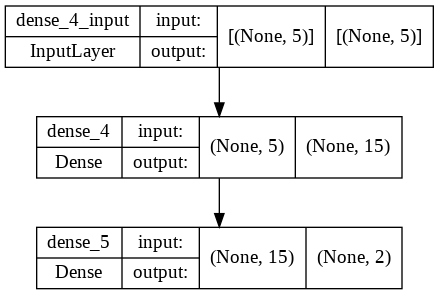

In [7]:
# define the generator model
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

# define the discriminator model
model = define_generator(5)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

## 3.2 latent space and fake sample generation

The first step is to generate new points in the latent space. We can achieve this by calling the [randn() NumPy function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randn.html) for generating arrays of [random numbers](https://machinelearningmastery.com/how-to-generate-random-numbers-in-python/) drawn from a standard Gaussian.

The array of random numbers can then be reshaped into samples: that is $n$ rows with $5$ elements per row. The ***generate_latent_points()*** function below implements this and generates the desired number of points in the latent space that can be used as input to the generator model.  Code example as below:

In [8]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

Next, we can use the generated points as input the generator model to generate new samples, then plot the samples.

The ***generate_fake_samples()*** function below implements this, where the defined generator and size of the latent space are passed as arguments, along with the number of points for the model to generate.

In [9]:
# use the generator to generate n fake examples and plot the results
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# plot the results
	pyplot.scatter(X[:, 0], X[:, 1])
	pyplot.show()

putting all together

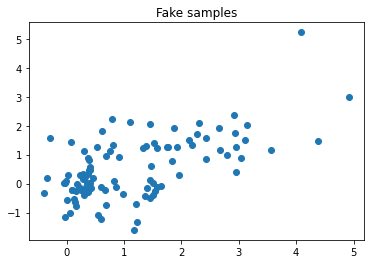

In [21]:
# define and use the generator model
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

# use the generator to generate n fake examples and plot the results
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# plot the results
	pyplot.scatter(X[:, 0], X[:, 1])
	pyplot.title('Fake samples')
	pyplot.show()

# size of the latent space
latent_dim = 5
# define the discriminator model
model = define_generator(latent_dim)
# generate and plot generated samples
generate_fake_samples(model, latent_dim, 100)



Running the example generates 100 random points from the latent space, uses this as input to the generator and generates 100 fake samples from our one-dimensional function domain.

* Note: As the generator has not been trained, the generated points are complete rubbish, as we expect, but **we can imagine that as the model is trained, these points will slowly begin to resemble the target function and its u-shape**.

# 4.. Training the Generator Model

The weights in the generator model are updated based on the performance of the discriminator model.

When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

This defines the **zero-sum** or adversarial relationship between these two models.

There may be many ways to implement this using the Keras API, but perhaps the simplest approach is to create a new model that subsumes or encapsulates the generator and discriminator models.

Specifically, a new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space, generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

To be clear, we are not talking about a new third model, just a logical third model that uses the already-defined layers and weights from the standalone generator and discriminator models.

Only the discriminator is concerned with distinguishing between real and fake examples; therefore, the discriminator model can be trained in a standalone manner on examples of each.



The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

When training the generator via this subsumed GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).

We can imagine that the discriminator will then classify the generated samples as not real (class 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating plausible fake samples.

Let’s make this concrete.

* **Inputs**: Point in latent space, e.g. a five-element vector of Gaussian random numbers.
* **Outputs**: Binary classification, likelihood the sample is real (or fake).

The ***define_gan()*** function below takes as arguments the already-defined generator and discriminator models and creates the new logical third model subsuming these two models. **The weights in the discriminator are marked as not trainable**, which only affects the weights as seen by the GAN model and not the standalone discriminator model.

The GAN model then uses the same **binary cross entropy loss function** as the discriminator and the efficient [Adam version of stochastic gradient descent](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/).  The code snippet as below:

In [11]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

Making the discriminator not trainable is a clever trick in the Keras API.

The **trainable** property impacts the model when it is compiled. The discriminator model was compiled with trainable layers, therefore the model weights in those layers will be updated when the standalone model is updated via calls to ***train_on_batch()***.

The **discriminator** model was marked as **not trainable**, added to the GAN model, and compiled. In this model, the model weights of the discriminator model are not trainable and cannot be changed when the GAN model is updated via calls to ***train_on_batch()***.

This behavior is described in the Keras API documentation here:

* [How can I “freeze” Keras layers?](https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers)

The complete example of creating the discriminator, generator, and composite model is listed below.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 2)                 122       
                                                                 
 sequential_4 (Sequential)   (None, 1)                 101       
                                                                 
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


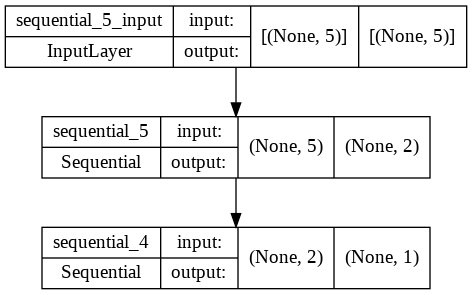

In [12]:
# demonstrate creating the three models in the gan
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

# define the standalone discriminator model
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

Training the composite model involves generating a batch-worth of points in the latent space via the ***generate_latent_points()*** function in the previous section, and class=1 labels and calling the ***train_on_batch()*** function.

The ***train_gan()*** function below demonstrates this, although it is pretty uninteresting as **only the generator will be updated each epoch**, ***leaving the discriminator with default model weights***.

In [13]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=10000, n_batch=128):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

Instead, what is required is that we:
1.  first update the discriminator model with real and fake samples, 
2. then update the generator via the composite model.

This requires combining elements from the ***train_discriminator()*** function defined in the discriminator section and the ***train_gan()*** function defined above. It also requires that the ***generate_fake_samples()*** function use the generator model to generate fake samples instead of generating random numbers.

The complete train function for updating the discriminator model and the generator (via the composite model) is listed below.

In [14]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

We almost have everything we need to develop a GAN for our one-dimensional function.

One remaining aspect is the evaluation of the model.

# 6.. Complete Example of Training the GAN

1999 0.3700000047683716 0.0


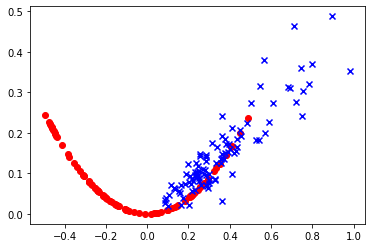

3999 0.47999998927116394 1.0


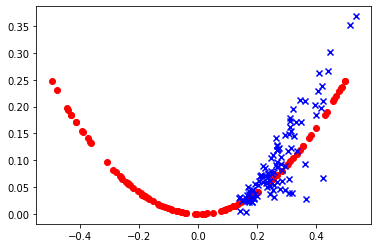

5999 0.28999999165534973 0.46000000834465027


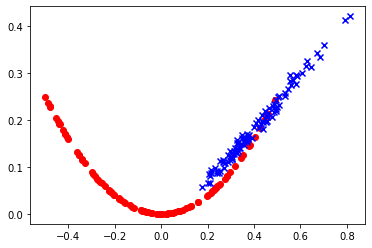

7999 0.11999999731779099 1.0


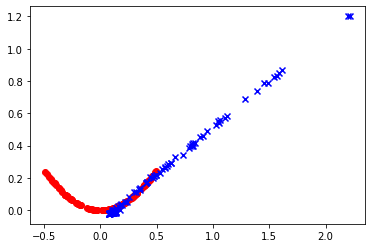

9999 0.4399999976158142 1.0


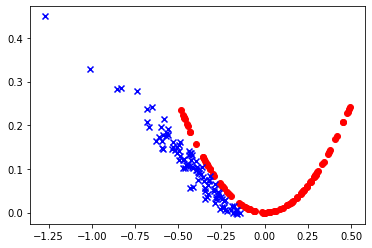

In [15]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

# generate n real samples with class labels
def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue', marker='x')
	pyplot.show()

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)

# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)